In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import sys
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline


In [16]:
profs = snp.load_single_node_profiles()

In [24]:
node_profs = {name : profiler.NodeProfile(name, profs[name], "latency_stage") for name in profs.keys()}

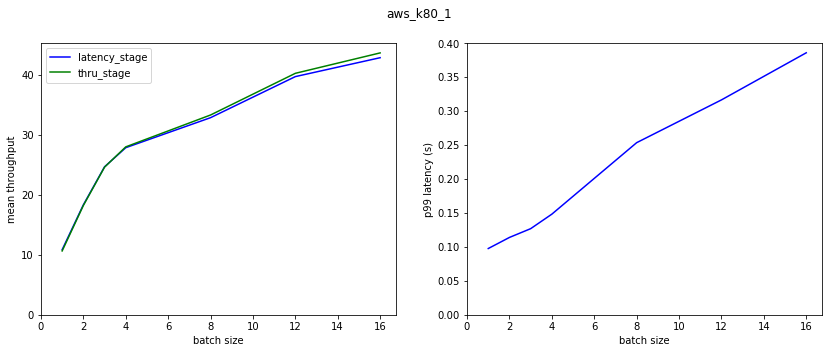

In [25]:
node_profs["tf-resnet-feats"].plot_profile()

In [ ]:
node_profs["res50"].plot_profile()

In [ ]:
name = "/Users/crankshaw/clipper-project/model-comp-project/plots-model-comp-paper/results_cpp_benchmarker/single_model_profs/pytorch-res50"
summaries = {}
for f in os.listdir(name):
    if "p100" in f:
        with open(os.path.join(name, f), "r") as g:
            summaries[f] = json.load(g)["summary_metrics"]

## Parse output log:

In [ ]:
def filter(line):
    if "Setting delay to" in line:
            return True
    elif "Throughput:" in line:
        return True
    elif "queues:" in line:
        return True
    elif "Driver command:" in line:
        return True
    else:
        return False

path = os.path.abspath("../results/profiler_debugging/output.log")
with open(path, "r") as f:
    lines = f.readlines()
lines = [l.strip() for l in lines if filter(l)]
i = 0
cur_run = None
all_runs = []
state = None
STEADY = "steady"
WARM = "warm"
INIT = "init"
while i < len(lines):
    if "Driver command" in lines[i]:
        if state == STEADY:
            all_runs.append(cur_run)
            cur_run = {WARM: [], INIT: [], STEADY: []}
            state = WARM
        elif state is None:
            cur_run = {WARM: [], INIT: [], STEADY: []}
            state = WARM
        elif state == WARM:
            state = INIT
        elif state == INIT:
            state = STEADY
    elif "Throughput:" in lines[i]:
        thru = lines[i]
        i += 1
        assert "queues:" in lines[i]
        queue = lines[i]
        if state == WARM:
            cur_run[WARM].append((thru, queue))
        elif state == INIT:
            cur_run[INIT].append((thru, queue))
        elif state == STEADY:
            cur_run[STEADY].append((thru, queue))
    elif "Setting delay to" in lines[i]:
        cur_run["delay"] = lines[i]
    i += 1

    
def extract_thru(trial):
    return float(trial[0].split(",")[0].split(": ")[2].rstrip("}"))

def extract_p99(trial):
    return float(trial[0].split(",")[1].split(": ")[2].rstrip("}")) / 1000.0

def extract_queue(trial):
    return float(trial[1].split(",")[0].split(": ")[2].rstrip("}"))

def extract_batches(trial):
    return float(trial[1].split(",")[1].split(": ")[2].rstrip("}"))

stats = []

for run in all_runs:
    s = {}
    delay = int(run["delay"].split("Setting delay to")[1].split()[0])
    s["delay"] = delay
    s["delay_inverse"] = 1000.0*1000.0/float(delay)
    for stage in [INIT, STEADY]:
        s[stage] = {}
        thrus = [extract_thru(trial) for trial in run[stage]]
        queues = [extract_queue(trial) for trial in run[stage]]
        batches = [extract_batches(trial) for trial in run[stage]]
        p99s = [extract_p99(trial) for trial in run[stage]]
        s[stage]["mean_thru"] = np.mean(thrus)
        s[stage]["std_thru"] = np.std(thrus)
        s[stage]["mean_queue"] = np.mean(queues)
        s[stage]["std_queue"] = np.std(queues)
        s[stage]["mean_batch"] = np.mean(batches)
        s[stage]["mean_p99"] = np.mean(p99s)
        s[stage]["std_p99"] = np.std(p99s)
    stats.append(s)
        

In [ ]:
# for s in stats:
#     print(json.dumps(s, indent=2))

init_thrus = [s[INIT]["mean_thru"] for s in stats]
init_thrus_std = [s[INIT]["std_thru"] for s in stats]
steady_thrus = [s[STEADY]["mean_thru"] for s in stats]
steady_thrus_std = [s[STEADY]["std_thru"] for s in stats]
init_queues = [s[INIT]["mean_queue"] for s in stats]
init_batches = [s[INIT]["mean_batch"] for s in stats]
steady_queues = [s[STEADY]["mean_queue"] for s in stats]
steady_batches = [s[STEADY]["mean_batch"] for s in stats]
steady_p99s = [s[STEADY]["mean_p99"] for s in stats]
steady_p99s_std = [s[STEADY]["std_p99"] for s in stats]


fig, (ax_thru, ax_queue, ax_lat) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax_thru.errorbar(init_batches, init_thrus, yerr=init_thrus_std, color="r", label=INIT, fmt="o")
# ax_queue.plot(init_batches, init_queues, color="r", label=INIT)
ax_thru.errorbar(steady_batches, steady_thrus, yerr=steady_thrus_std, color="b", label=STEADY, fmt="o")
ax_queue.plot(steady_batches, steady_queues, color="b", label=STEADY)
ax_lat.errorbar(steady_batches, steady_p99s, yerr=steady_p99s_std, color="b", label=STEADY, fmt="o")

ax_thru.set_ylabel("Mean throughput (qps)")
ax_thru.set_xlabel("batch size")
ax_thru.legend(loc=0)

ax_queue.set_ylabel("Mean queue size")
ax_queue.set_xlabel("batch size")
ax_queue.legend(loc=0)

ax_lat.set_ylabel("p99 latency (s)")
ax_lat.set_xlabel("batch size")
ax_lat.legend(loc=0)


plt.show()